# 07. 성능향상 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob


## 과제: 개 고양이 분류 모델 만들기

아래 텐서플로우 글을 참고하세요

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

---
### **데이터셋**
---



<p align='center'>
<img src=https://www.tensorflow.org/tutorials/images/transfer_learning_files/output_K5BeQyKThC_Y_0.png?hl=ko  width=400>
</p>


#### **이미지 데이터 경로 설정**

* 데이터 불러오기
  * https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
N_CLASS = 2


68616192/68606236 [==============================] - 1s 0us/step


#### **텐서플로우 데이터셋 준비**

In [ ]:
train_ds = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE))
valid_ds= image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
train_ds.class_names

['cats', 'dogs']

* 데이터셋 시각화

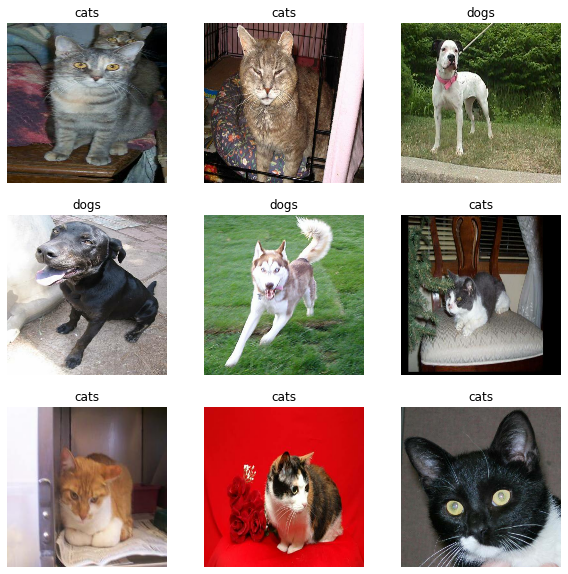

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
### **성능 향상 기법 적용**
---

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers

In [ ]:
aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

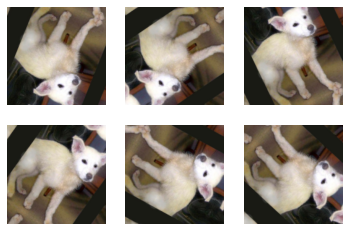

In [ ]:
for imgs, labels, in train_ds.take(1):
  img = imgs[0]
  for i in range(6):
    plt.subplot(2,3,i+1)
    aug_img = aug(img)
    plt.imshow(aug_img/255)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras import applications
base_model = applications.MobileNetV2(input_shape=(160,160,3),
                                      include_top=False,
                                      weights='imagenet')
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
base_model.trainable = False

In [ ]:
x = layers.Input(shape=(160,160,3))
z = aug(x)                                    
z = applications.mobilenet_v2.preprocess_input(z) 
z = base_model(z,training= False)
z = layers.GlobalAveragePooling2D()(z) 
z = layers.Dropout(0.2)(z)
y = layers.Dense(N_CLASS,activation='sigmoid')(z)
transfer = models.Model(x,y)
transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (160, 160, 3)             0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        factor=0.2,
                                        patience=3,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint(filepath='transfer.h5',save_best_only=True)

In [ ]:
transfer.compile(loss = losses.SparseCategoricalCrossentropy(),
                 optimizer =optimizers.RMSprop(learning_rate=0.0001),
                 metrics = ['accuracy'])

In [ ]:
history_transfer  = transfer.fit(train_ds, 
                                 validation_data=valid_ds,
                                 epochs =20,
                                callbacks = [reduce_lr,ckp])

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
transfer.evaluate(valid_ds)

In [ ]:
def plot_lcurve(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  plt.style.use('ggplot')
  plt.figure(figsize = (15,5))

  plt.subplot(1,2,1)
  plt.title('Accuracy')
  plt.plot(acc, marker='.', label = 'train')
  plt.plot(val_acc, marker='.' , label = 'valid')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title("loss")
  plt.plot(loss, marker='.' , label = 'train')
  plt.plot(val_loss, marker='.' ,label = 'valid')
  plt.legend()
  plt.show()

In [ ]:
plot_lcurve(history_transfer)

In [ ]:
base_model.trainable = True

In [ ]:
print(len(base_model.layers))
for layer in base_model.layers[:100]:
  layer.trainable = False
  

In [ ]:
transfer.summary()

In [ ]:
transfer.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer = optimizers.RMSprop(learning_rate=0.0001/10),
              metrics = ['accuracy'])

In [ ]:
history_fine = transfer.fit(train_ds,
                            epochs = 20,
                            validation_data=valid_ds,
                            callbacks=[ckp,reduce_lr])

**성능평가**

* 평가

In [ ]:
transfer.evaluate(valid_ds)

* learning curve

In [ ]:
plot_lcurve(history_fine)

---
### **모델 사용**
---

In [ ]:
transfer.save('dogcat_classifier.h5')

In [ ]:
dogcat_model = models.load_model('dogcat_classifier.h5')

* `valid_ds` 로 테스트

In [ ]:
from tensorflow.keras import preprocessing

(160, 160, 3) (32,)
(32, 2)
[1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
[1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]


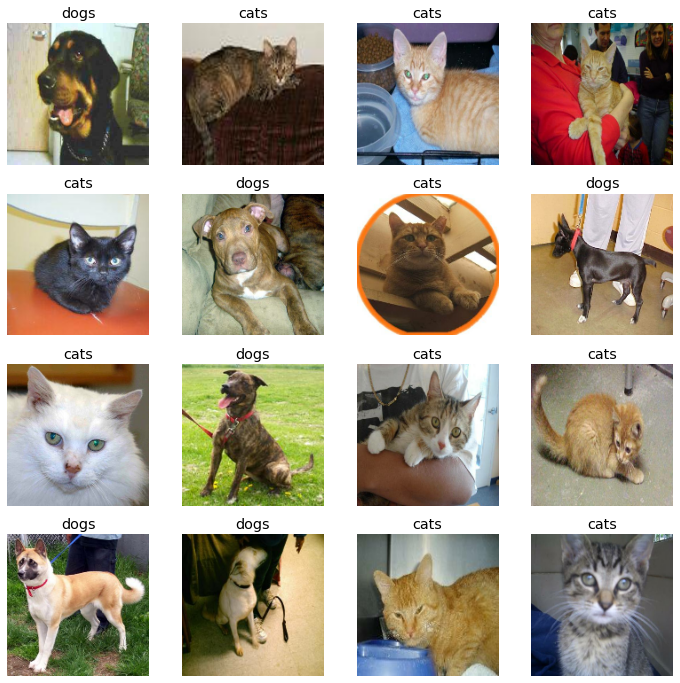

In [ ]:
imgs, labels = valid_ds.as_numpy_iterator().next()
print(img.shape,labels.shape)
preds = transfer.predict_on_batch(imgs)
print(preds.shape)
preds = np.argmax(preds,axis=1)
print(preds)
print(labels)
plt.figure(figsize=(12,12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i].astype("uint8"))
  plt.title(valid_ds.class_names[preds[i]])
  plt.axis('off')
plt.show()

* 새로운 이미지로 테스트

<PIL.Image.Image image mode=RGB size=160x160 at 0x7FD71316A8D0>
[1]


(-0.5, 159.5, 159.5, -0.5)

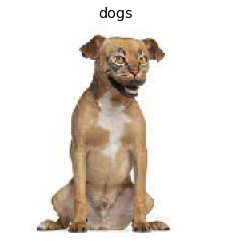

In [ ]:
img_path = 'dogcat.jpg'
#img = plt.imread(img_path)
img = preprocessing.image.load_img(img_path,
                                   target_size=(160,160))
print(img)
img_arr = preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)   #(1,160,160,3)
pred = transfer.predict_on_batch(img_arr)
pred= np.argmax(pred,axis=1)
print(pred)

plt.title(train_ds.class_names[pred[0]])
plt.imshow(img)
plt.axis('off')

